In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

triads = [['BPS'+str(i),'BPS'+str(i+20),'BPS'+str(i+40)] for i in range(1,21)]
pd.options.display.max_columns= 79

In [2]:
#import datafile

df = pd.read_csv('new_test/20TH jUNE 24HOUR DATA.csv')

In [3]:
#define algos and parameters

def pre_thresholding(y, lag_w, lag_HF, influence):
   
    #initialize arrays for signals(peaks/dips), filtered output(smoothened), avgfilter(mean), stdfilter(std dev)
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    
    #calculate mean of moving window
    avgFilter[lag_w - 1] = np.mean(y[0:lag_w])
    
    
    
    #run the moving window over input signal. Skips first n points. (n=lag)
    for i in range(lag_w, len(y)):
        
        
        if i > (lag_w + lag_HF+ 1):
            
            
            Mavg_now = avgFilter[i-1]
            Mavg_60= avgFilter[i-lag_HF-1]
            
           
            if ((((Mavg_now- Mavg_60)/Mavg_60)*100) < -2.6):
                signals[i] = -1
                    
                
                        
            #output filtered signal with smoothened peak/dip
            filteredY[i] = y[i]
            
            #calculate mean for next step of moving window
            avgFilter[i] = np.mean(filteredY[(i-lag_w+1):i+1])
            
           
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag_w+1):i+1])
            

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter))


'''
moving window over 30 data points,
signals peaks/valleys if data point exceeds 3.5 std. deviation of moving mean
signals get 0.2 value of regular points for calculating moving mean
'''

lag_w = 5
lag_HF= 60
influence_=0.1


y1= df['HF_RIGHT'].to_numpy()
y2 = df['HF_FIX'].to_numpy()

result_rt = pre_thresholding(y1, lag_w=lag_w, lag_HF=lag_HF, influence=influence_)
result_fix = pre_thresholding(y2, lag_w=lag_w, lag_HF=lag_HF, influence=influence_)


C:\Users\Ryzen\AppData\Local\Temp/ipykernel_17628/227116627.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  if ((((Mavg_now- Mavg_60)/Mavg_60)*100) < -2.6):


In [10]:
#define algos and parameters

def thresholding_algo(y, lag, threshold, influence, ratio=2):
    
    pts=[5,6,7,8,9]
    #initialize arrays for signals(peaks/dips), filtered output(smoothened), avgfilter(mean), stdfilter(std dev)
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    
    #calculate mean of moving window
    avgFilter[lag - 1] = np.mean(y[0:lag])
    
    #calculate std dev of moving window
    stdFilter[lag - 1] = np.std(y[0:lag])
    
    
    #run the moving window over input signal. Skips first n points. (n=lag)
    for i in range(lag, len(y)):
        
        
        cs_max= df['CAST_SPEED_ACT'][i-lag:i-1].max()
        cs_min= df['CAST_SPEED_ACT'][i-lag:i-1].min()
        cs_act=df['CAST_SPEED_ACT'].iloc[i]
        
        #check if current point is certain std dev away from mean of moving window
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                #check if right or fix hf condition fullfilled
                if (result_rt['signals'][i]== -1.0) or (result_fix['signals'][i]== -1.0):
                    
                    #check for cast-speed slowdown/speed-up
                    if ((abs(cs_act-cs_min)<=0.1) and (abs(cs_max-cs_act)<=0.1)):
                
                        #check if dip is indeed low by certain magnitudes compared to past points (5,6,7 points befote)
                        if (y[i-pts[0]]- y[i]>=ratio*pts[0]) or (y[i-pts[1]]- y[i]>=ratio*pts[1]) or (y[i-pts[2]]- y[i]>=ratio*pts[2]) or (y[i-pts[3]]- y[i]>=ratio*pts[3]) or (y[i-pts[4]]- y[i]>=ratio*pts[4]):
                        
                            #flag dip
                            signals[i] = -1
                    
                
                        
            #output filtered signal with smoothened peak/dip
            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            
            #calculate mean for next step of moving window
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            
            #calculate std dev for next step of moving window
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

def thresholding_algo2(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

'''
moving window over 30 data points,
signals peaks/valleys if data point exceeds 3.5 std. deviation of moving mean
signals get 0.2 value of regular points for calculating moving mean
'''

lag = 15
threshold = 3.0
influence = 0.1

In [11]:

#apply algo on each of the triads

c_result= []
funnel = []
for curr in triads[0:20]:
    
    y1 = df[curr[0]].to_numpy()
    y2 = df[curr[1]].to_numpy()
    y3 = df[curr[2]].to_numpy()
    
    num=len(y1)

    
    # Run algo with settings from above
    result1 = thresholding_algo(y1, lag=lag, threshold=threshold, influence=influence, ratio=2)
    result2 = thresholding_algo(y2, lag=lag, threshold=threshold, influence=influence, ratio=2)
    result3 = thresholding_algo(y3, lag=lag, threshold=3.0, influence=influence, ratio=2)
    #result3 = thresholding_algo2(y3, lag=lag, threshold=3.0, influence=influence)

    #store dips of each thermocouple
    locations1=[]
    for i in range(len(result1['signals'])):
        if result1['signals'][i] == -1.0:
            locations1.append(i)

    locations2=[]
    for i in range(len(result2['signals'])):
        if result2['signals'][i] == -1.0:
            locations2.append(i)

    locations3=[]
    for i in range(len(result3['signals'])):
        if result3['signals'][i] == -1.0:
            locations3.append(i)
            
    #find intersection of dips
    result_set=[]
    for i in locations1:
        if ((i+2) in locations2 or(i+1) in locations2 or i in locations2 or (i-1) in locations2 or (i-2) in locations2) and ((i+2) in locations3 or(i+1) in locations3 or i in locations3 or (i-1) in locations3 or (i-2) in locations3):
            result_set.append(i)        
  
    result_set= list(result_set)
    result_set.sort()
    
    ## take only first from consecutive points
    for i in result_set:
        flag=True
        n=1
        while(flag):
            if (i+n) in result_set:
                result_set.remove(i+n)
                n=n+1
            else:
                flag=False
            
            
    funnel.append(len(result_set))
    c_result.append(result_set)
    print(curr[0] + ' + ' + curr[1] + ' + ' + curr[2] + ' = ' + str(result_set)+ '\n\n')

BPS1 + BPS21 + BPS41 = []


BPS2 + BPS22 + BPS42 = []


BPS3 + BPS23 + BPS43 = []


BPS4 + BPS24 + BPS44 = []


BPS5 + BPS25 + BPS45 = []


BPS6 + BPS26 + BPS46 = [3357, 13701, 21336]


BPS7 + BPS27 + BPS47 = []


BPS8 + BPS28 + BPS48 = []


BPS9 + BPS29 + BPS49 = []


BPS10 + BPS30 + BPS50 = []


BPS11 + BPS31 + BPS51 = []


BPS12 + BPS32 + BPS52 = []


BPS13 + BPS33 + BPS53 = []


BPS14 + BPS34 + BPS54 = []


BPS15 + BPS35 + BPS55 = []


BPS16 + BPS36 + BPS56 = []


BPS17 + BPS37 + BPS57 = [6724, 6726, 9874, 9882, 19662, 20302, 27232, 28303, 28352]


BPS18 + BPS38 + BPS58 = []


BPS19 + BPS39 + BPS59 = []


BPS20 + BPS40 + BPS60 = [36193]




In [15]:
#store dip points

df_val1=pd.DataFrame(columns=['Index','Time','Met_length','Triad', 'Type', 'Algo' , 'Name'])
#df_val1=pd.DataFrame(columns=['Index','Time','Triad', 'Type', 'Algo' , 'Name'])
counter=0
for i in range(len(c_result)):
    for j in range(len(c_result[i])):
        result=(c_result[i][j])
        df_val1.loc[counter]=pd.Series({'Index':result, 'Time':df.iloc[result]['TIME_STAMP'], 'Met_length':str(df.iloc[result]['MET_LENGTH']), 'Triad':triads[i], 'Type':'Wide','Algo': 'Z-Score', 'Name': " ".join(triads[i])})
        #df_val1.loc[counter]=pd.Series({'Index':result, 'Time':df.iloc[result]['TIME_STAMP'], 'Triad':triads[i], 'Type':'Wide','Algo': 'Z-Score', 'Name': " ".join(triads[i])})
        counter=counter+1
        

c1_wide=df_val1.sort_values(by='Index', ascending=True)
print('-'*100)
print(' '*35+ 'Dips through Z-Score')
print('-'*100)
c1_wide=c1_wide[~((c1_wide['Name'].str.contains('BPS11')) | (c1_wide['Name'].str.contains('BPS1 '))| (c1_wide['Name'].str.contains('BPS12')) | (c1_wide['Name'].str.contains('BPS2 ')) | (c1_wide['Name'].str.contains('BPS20')) | (c1_wide['Name'].str.contains('BPS10')) | (c1_wide['Name'].str.contains('BPS3 ')))]
#c1_wide=c1_wide.drop(columns=['Name'])
#c1_wide.loc[1]=pd.Series(c1_wide.loc[0])
c1_wide

----------------------------------------------------------------------------------------------------
                                   Dips through Z-Score
----------------------------------------------------------------------------------------------------


,Index,Time,Met_length,Triad,Type,Algo,Name
0,3357,19-06-22 19:05:35,8270.931,"[BPS6, BPS26, BPS46]",Wide,Z-Score,BPS6 BPS26 BPS46
3,6724,19-06-22 20:52:29,8344.493,"[BPS17, BPS37, BPS57]",Wide,Z-Score,BPS17 BPS37 BPS57
4,6726,19-06-22 20:52:32,8344.489,"[BPS17, BPS37, BPS57]",Wide,Z-Score,BPS17 BPS37 BPS57
5,9874,19-06-22 22:32:14,8119.645,"[BPS17, BPS37, BPS57]",Wide,Z-Score,BPS17 BPS37 BPS57
6,9882,19-06-22 22:32:26,8104.746,"[BPS17, BPS37, BPS57]",Wide,Z-Score,BPS17 BPS37 BPS57
1,13701,20-06-22 00:33:44,6675.955,"[BPS6, BPS26, BPS46]",Wide,Z-Score,BPS6 BPS26 BPS46
7,19662,20-06-22 03:42:51,6864.713,"[BPS17, BPS37, BPS57]",Wide,Z-Score,BPS17 BPS37 BPS57
8,20302,20-06-22 04:03:01,7436.124,"[BPS17, BPS37, BPS57]",Wide,Z-Score,BPS17 BPS37 BPS57
2,21336,20-06-22 04:35:43,7436.124,"[BPS6, BPS26, BPS46]",Wide,Z-Score,BPS6 BPS26 BPS46
9,27232,20-06-22 07:43:02,7183.821,"[BPS17, BPS37, BPS57]",Wide,Z-Score,BPS17 BPS37 BPS57


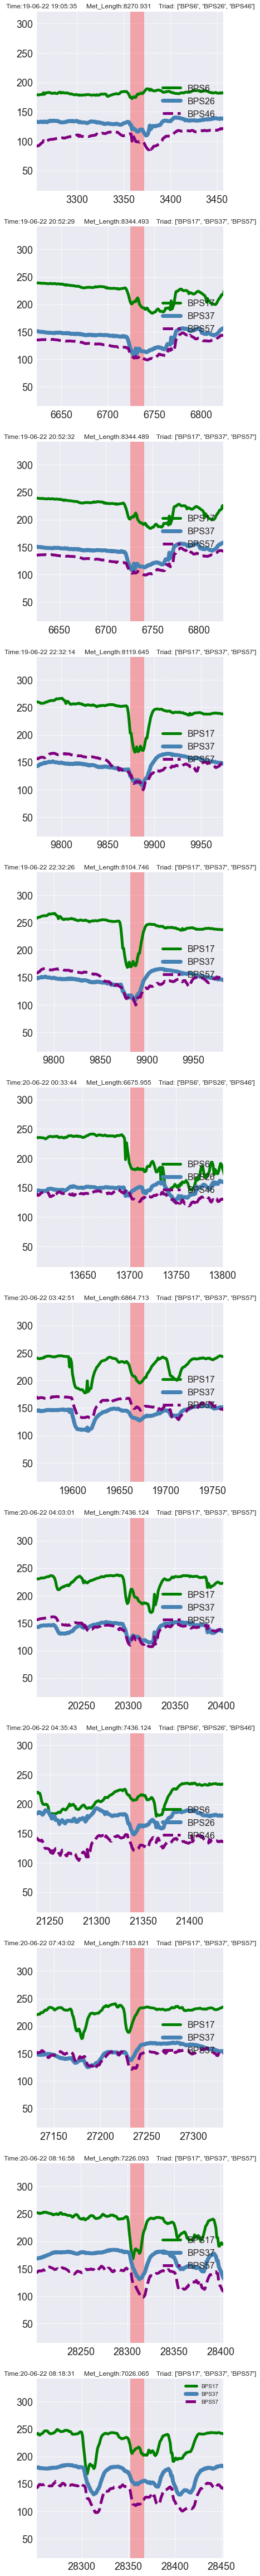

In [18]:
#plotting detected dips

plt.style.use("seaborn")

fig, axs = plt.subplots(len(c1_wide), figsize=(6, 7*len(c1_wide)))
for i in range(len(c1_wide)):
    Title= str('Time:'+c1_wide.iloc[i]['Time'])+'     Met_Length:'+str(c1_wide.iloc[i]['Met_length'])+'    Triad: '+str(c1_wide.iloc[i]['Triad'])
    #Title= str('Time:'+c1_wide.iloc[i]['Time'])+ str(c1_wide.iloc[i]['Triad'])
    det= int(c1_wide.iloc[i]['Index'])
    tr= c1_wide.iloc[i]['Triad']
    
    colors= ['green', 'steelblue', 'purple']
    l_width=[5,7,5]
    l_style=['solid', 'solid', 'dashed']
    for j in range(3):
        axs[i].plot(df[tr[j]],label=tr[j], linewidth=l_width[j], color=colors[j], linestyle=l_style[j])
    axs[i].axvspan(det,det+15, facecolor='r', alpha=0.3)
    axs[i].set_title(Title)
    axs[i].tick_params(axis='both', labelsize=18)
    
    axs[i].legend(fontsize=16, loc='center right')
    axs[i].grid(axis = 'both', linestyle='--')
    axs[i].set_xlim(det-100,det+100)
plt.legend()
plt.show()
    

In [27]:
#save dip points as csv file

c1_wide.to_csv('dump/integrated_hf_tc.csv')